# <center><u>MicaSense RedEdge Calibration Testing</center></u>

In [1]:
# import relevant modules / packages
import cv2
import numpy as np
import os,glob
import math
import gdal
import micasense.metadata as metadata
import micasense.utils as msutils
import matplotlib.pyplot as plt
%matplotlib inline

# specify ExifTool path
exiftoolPath = None
if os.name == 'posix':
    exiftoolPath = '/usr/local/bin/exiftool'

## 1. Calibration Panel Image

### 1.1. Open Calibration Panel Image and Retrieve Metadata

In [2]:
Calib_Im_Path = "data/0036SET/calib/IMG_0008_3.tif"

# read raw image DN values
imageRaw = gdal.Open(Calib_Im_Path).ReadAsArray()

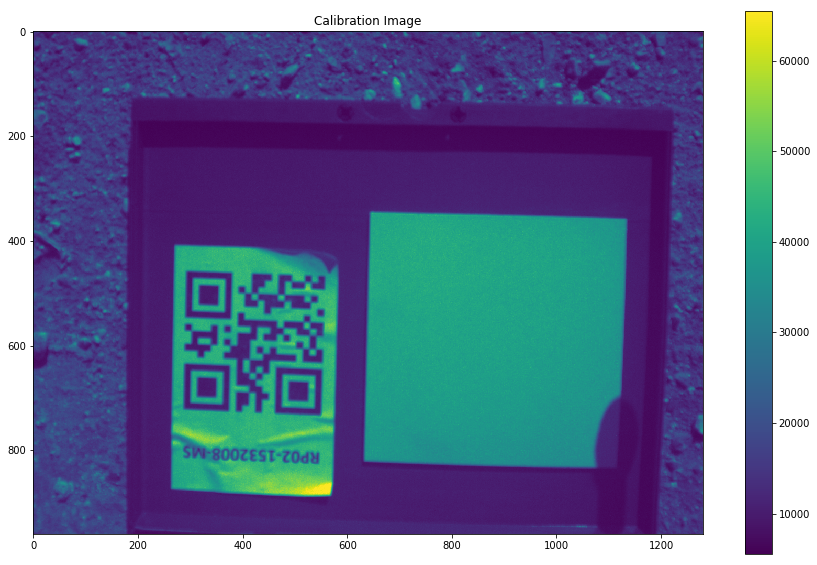

In [3]:
# plot the image
plt.figure(figsize=(15,10))
plt.imshow(imageRaw)
plt.title("Calibration Image")
plt.colorbar()
plt.show()

In [4]:
# get image metadata
meta = metadata.Metadata(Calib_Im_Path, exiftoolPath=exiftoolPath)
cameraMake = meta.get_item('EXIF:Make')
cameraModel = meta.get_item('EXIF:Model')
firmwareVersion = meta.get_item('EXIF:Software')
bandName = meta.get_item('XMP:BandName')

In [5]:
# print image metadata
print('{0} {1} firmware version: {2}'.format(cameraMake, cameraModel, firmwareVersion))
print('Exposure Time: {0} seconds'.format(meta.get_item('EXIF:ExposureTime')))
print('Imager Gain: {0}'.format(meta.get_item('EXIF:ISOSpeed')/100.0))
print('Size: {0}x{1} pixels'.format(meta.get_item('EXIF:ImageWidth'),meta.get_item('EXIF:ImageHeight')))
print('Band Name: {0}'.format(bandName))
print('Center Wavelength: {0} nm'.format(meta.get_item('XMP:CentralWavelength')))
print('Bandwidth: {0} nm'.format(meta.get_item('XMP:WavelengthFWHM')))
print('Capture ID: {0}'.format(meta.get_item('XMP:CaptureId')))
print('Flight ID: {0}'.format(meta.get_item('XMP:FlightId')))

MicaSense RedEdge firmware version: v2.1.2
Exposure Time: 0.000698 seconds
Imager Gain: 1.0
Size: 1280x960 pixels
Band Name: Red
Center Wavelength: 668 nm
Bandwidth: 10 nm
Capture ID: xqOEhdy3WausclxCYCQn
Flight ID: eBZmBxH76asozV3vrX8c


### 1.2. Convert Raw Calibration Panel Image to Radiance

In [6]:
# convert raw calobration image to radiance
radianceImage, L, V, R = msutils.raw_image_to_radiance(meta, imageRaw)

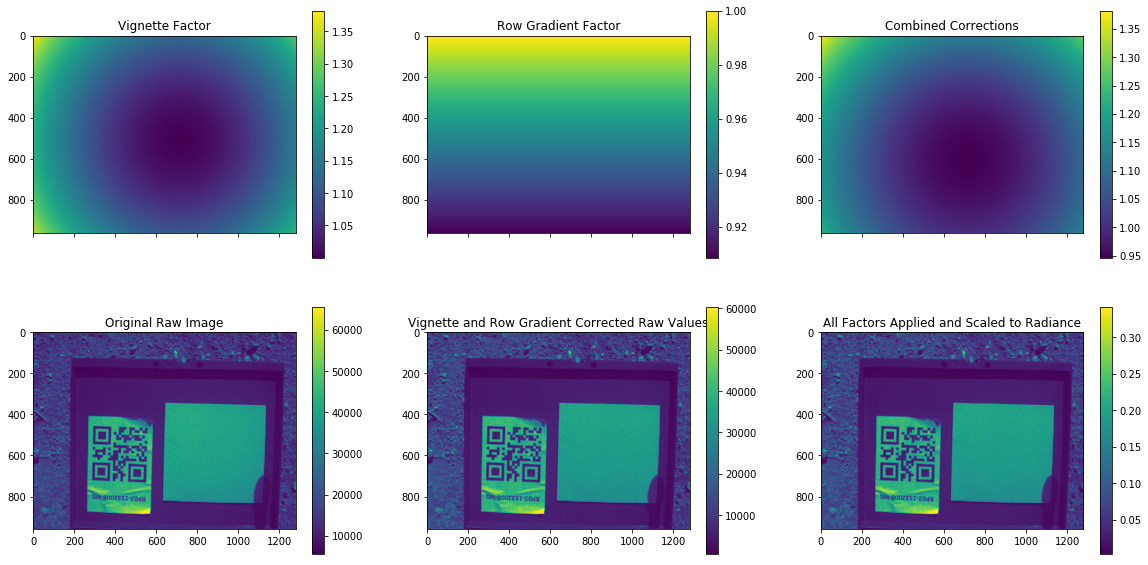

In [7]:
# plot converted images
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,10), sharex=True, sharey=False)

V_im = ax[0,0].imshow(V)
ax[0,0].set_adjustable("box-forced")
ax[0,0].set_title("Vignette Factor")
fig.colorbar(V_im, ax=ax[0,0])

R_im = ax[0,1].imshow(R)
ax[0,1].set_adjustable("box-forced")
ax[0,1].set_title("Row Gradient Factor")
fig.colorbar(R_im, ax=ax[0,1])

VR_im = ax[0,2].imshow(V*R)
ax[0,2].set_adjustable("box-forced")
ax[0,2].set_title("Combined Corrections")
fig.colorbar(VR_im, ax=ax[0,2])

IR_im = ax[1,0].imshow(imageRaw)
ax[1,0].set_adjustable("box-forced")
ax[1,0].set_title("Original Raw Image")
fig.colorbar(IR_im, ax=ax[1,0])

L_im = ax[1,1].imshow(L)
ax[1,1].set_adjustable("box-forced")
ax[1,1].set_title("Vignette and Row Gradient Corrected Raw Values")
fig.colorbar(L_im, ax=ax[1,1])

Rad_im = ax[1,2].imshow(radianceImage)
ax[1,2].set_adjustable("box-forced")
ax[1,2].set_title("All Factors Applied and Scaled to Radiance")
fig.colorbar(Rad_im, ax=ax[1,2])

plt.show()

### 1.3. Convert Radiance Calibration Panel to Reflectance

In [8]:
# create copy of radiance calibration image
markedImg = radianceImage.copy()

# specify calibration panel location in image
ulx = 660 # upper left column (x coordinate) of panel area
uly = 380 # upper left row (y coordinate) of panel area
lrx = 1050 # lower right column (x coordinate) of panel area
lry = 800 # lower right row (y coordinate) of panel area

# create rectangle aound clibration panel in image
panel_rect = cv2.rectangle(markedImg,(ulx,uly),(lrx,lry),(0,255,0),3)

# panel calibration values by band (from MicaSense for specific panel)
panelCalibration = {"Blue": 0.67, "Green": 0.69, "Red": 0.68, "Red edge": 0.67, "NIR": 0.61}

# Define panel region in radiance image
panelRegion = radianceImage[uly:lry, ulx:lrx]

In [9]:
# find mean radiance value
meanRadiance = panelRegion.mean()
print('Mean Radiance in panel region: {:1.3f} W/m^2/nm/sr'.format(meanRadiance))

# find conversion factor
panelReflectance = panelCalibration[bandName]
radianceToReflectance = panelReflectance / meanRadiance
print('Radiance to reflectance conversion factor: {:1.3f}'.format(radianceToReflectance))

# convert image from radiance to reflectance
reflectanceImage = radianceImage * radianceToReflectance

Mean Radiance in panel region: 0.189 W/m^2/nm/sr
Radiance to reflectance conversion factor: 3.598


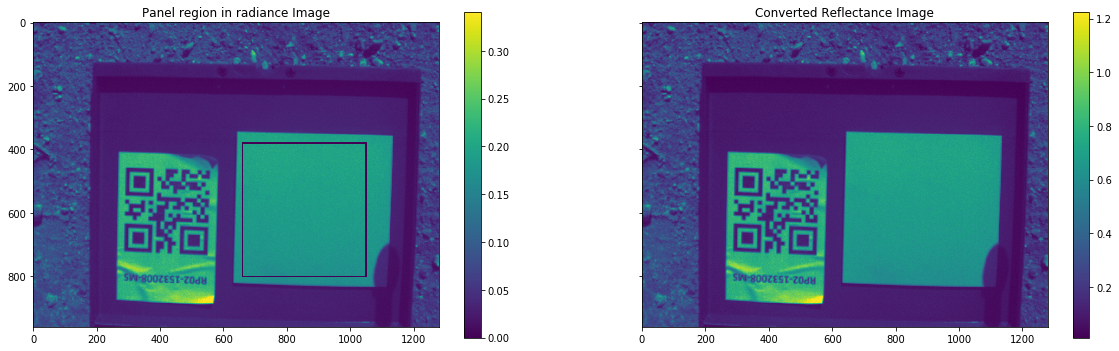

In [10]:
# plot the radiance and converted reflectance images
fig, ax = plt.subplots(ncols=2, figsize=(20,6), sharex=True, sharey=True)

Mar_im = ax[0].imshow(markedImg)
ax[0].set_adjustable("box-forced")
ax[0].set_title("Panel region in radiance Image")
fig.colorbar(Mar_im, ax=ax[0])

Refl_im = ax[1].imshow(reflectanceImage)
ax[1].set_adjustable("box-forced")
ax[1].set_title("Converted Reflectance Image")
fig.colorbar(Refl_im, ax=ax[1])

plt.show()

### 1.4. Verify the Reflectance Values of the Calibration Panel

In [11]:
# define panel region in reflectanc image
panelRegionRefl = reflectanceImage[uly:lry, ulx:lrx]

# apply Gaussian Blur to calibration panel region
panelRegionReflBlur = cv2.GaussianBlur(panelRegionRefl,(55,55),5)

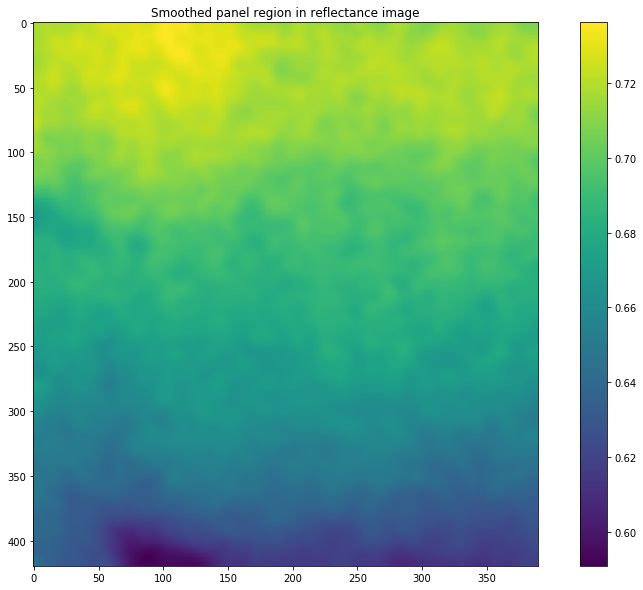

In [12]:
# plot Gaussian Blur panel image
plt.figure(figsize=(15,10))
plt.imshow(panelRegionReflBlur)
plt.title("Smoothed panel region in reflectance image")
plt.colorbar()
plt.show()

In [13]:
# compare reflectance values of converted panel to those expected (known reflectance values in specific bands)
print('Min Reflectance in panel region: {:1.2f}'.format(panelRegionRefl.min()))
print('Max Reflectance in panel region: {:1.2f}'.format(panelRegionRefl.max()))
print('Mean Reflectance in panel region: {:1.2f}'.format(panelRegionRefl.mean()))
print('Standard deviation in region: {:1.4f}'.format(panelRegionRefl.std()))
print ("\n---- COMPARISON ----\n")
print('Known Reflectance Value of MicaSense panel in {0}'.format(bandName), "waveband =", panelCalibration[bandName])

Min Reflectance in panel region: 0.56
Max Reflectance in panel region: 0.83
Mean Reflectance in panel region: 0.68
Standard deviation in region: 0.0351

---- COMPARISON ----

Known Reflectance Value of MicaSense panel in Red waveband = 0.68


### 1.5. Remove Minor Distortions of Reflectance Calibration Panel Image

In [14]:
# correct for lens distortions to make straight lines straight
undistortedReflectance = msutils.correct_lens_distortion(meta, reflectanceImage)

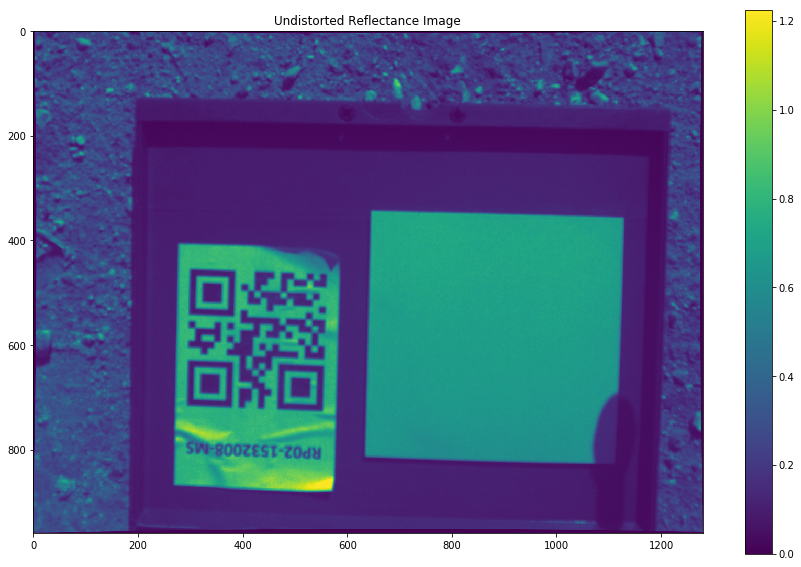

In [15]:
# plot calibration panel image after the removal of distortions
plt.figure(figsize=(15,10))
plt.imshow(undistortedReflectance)
plt.title("Undistorted Reflectance Image")
plt.colorbar()
plt.show()

## 2. Flight Image

### 2.1. Open Flight Image and Retrieve Metadata

In [16]:
# open flight image
flightImageName = "data/0036SET/001/1_IMG_0065_3.tif"

# read raw flight image as an array
flightImageRaw = gdal.Open(flightImageName).ReadAsArray()

In [17]:
# get flight image metadata
f_meta = metadata.Metadata(flightImageName, exiftoolPath=exiftoolPath)
f_cameraMake = f_meta.get_item('EXIF:Make')
f_cameraModel = f_meta.get_item('EXIF:Model')
f_firmwareVersion = f_meta.get_item('EXIF:Software')
f_bandName = f_meta.get_item('XMP:BandName')

In [18]:
# print flight image metadata to make sure it is the same band as the calibration panel image
print('---- Flight Image Metadata ----\n')
print('{0} {1} firmware version: {2}'.format(f_cameraMake, f_cameraModel, f_firmwareVersion))
print('Exposure Time: {0} seconds'.format(f_meta.get_item('EXIF:ExposureTime')))
print('Imager Gain: {0}'.format(f_meta.get_item('EXIF:ISOSpeed')/100.0))
print('Size: {0}x{1} pixels'.format(f_meta.get_item('EXIF:ImageWidth'), f_meta.get_item('EXIF:ImageHeight')))
print('Band Name: {0}'.format(f_bandName))
print('Center Wavelength: {0} nm'.format(f_meta.get_item('XMP:CentralWavelength')))
print('Bandwidth: {0} nm'.format(f_meta.get_item('XMP:WavelengthFWHM')))
print('Capture ID: {0}'.format(f_meta.get_item('XMP:CaptureId')))
print('Flight ID: {0}'.format(f_meta.get_item('XMP:FlightId')))

# print calibration panel image metadata for comparison
print('\n---- Calibration Panel Image Metadata ----\n')
print('{0} {1} firmware version: {2}'.format(cameraMake, cameraModel, firmwareVersion))
print('Exposure Time: {0} seconds'.format(meta.get_item('EXIF:ExposureTime')))
print('Imager Gain: {0}'.format(meta.get_item('EXIF:ISOSpeed')/100.0))
print('Size: {0}x{1} pixels'.format(meta.get_item('EXIF:ImageWidth'),meta.get_item('EXIF:ImageHeight')))
print('Band Name: {0}'.format(bandName))
print('Center Wavelength: {0} nm'.format(meta.get_item('XMP:CentralWavelength')))
print('Bandwidth: {0} nm'.format(meta.get_item('XMP:WavelengthFWHM')))
print('Capture ID: {0}'.format(meta.get_item('XMP:CaptureId')))
print('Flight ID: {0}'.format(meta.get_item('XMP:FlightId')))

---- Flight Image Metadata ----

MicaSense RedEdge firmware version: v2.1.2
Exposure Time: 0.001058 seconds
Imager Gain: 4.0
Size: 1280x960 pixels
Band Name: Red
Center Wavelength: 668 nm
Bandwidth: 10 nm
Capture ID: npGhySMQfP7i2O1Z1he0
Flight ID: eBZmBxH76asozV3vrX8c

---- Calibration Panel Image Metadata ----

MicaSense RedEdge firmware version: v2.1.2
Exposure Time: 0.000698 seconds
Imager Gain: 1.0
Size: 1280x960 pixels
Band Name: Red
Center Wavelength: 668 nm
Bandwidth: 10 nm
Capture ID: xqOEhdy3WausclxCYCQn
Flight ID: eBZmBxH76asozV3vrX8c


### 2.2. Convert Flight Image from Raw to Radiance to Reflectance and Remove Distortions

In [19]:
# convert flight image form raw to radiance
flightRadianceImage, _, _, _ = msutils.raw_image_to_radiance(meta, flightImageRaw)

# convert radiance flight image to reflectance using the calibration panel values
flightReflectanceImage = flightRadianceImage * radianceToReflectance

# correct flight image for distortions
flightUndistortedReflectance = msutils.correct_lens_distortion(meta, flightReflectanceImage)

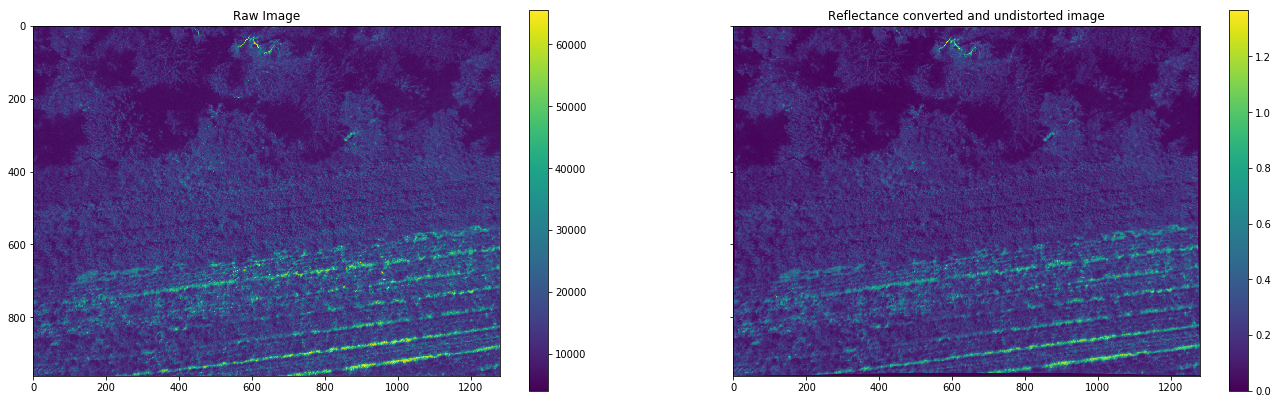

In [20]:
# plot raw and reflectance flight image
fig, ax = plt.subplots(ncols=2, figsize=(23,7), sharex=True, sharey=True)

FlR_im = ax[0].imshow(flightImageRaw)
ax[0].set_adjustable("box-forced")
ax[0].set_title("Raw Image")
fig.colorbar(FlR_im, ax=ax[0])

FUR_im = ax[1].imshow(flightUndistortedReflectance)
ax[1].set_adjustable("box-forced")
ax[1].set_title("Reflectance converted and undistorted image")
fig.colorbar(FUR_im, ax=ax[1])

plt.show()